# f(R) gravity with ReACT and ACTio-ReACTio

Firstly, we compute f(R) reaction function for $z = 1$ with ReACT

In [1]:
import numpy as np
import camb

%matplotlib inline
import matplotlib.pyplot as plt

import pyreact

Set the cosmology and let CAMB compute the linear power spectrum.

In [2]:
Omega_c = 0.25
Omega_b = 0.05
h = 0.7
n_s = 0.97
A_s = 2.1e-9
m_nu = 0.0
w0 = -1.0
w_a = 0.0
Omega_m = Omega_c+Omega_b

p = camb.CAMBparams(WantTransfer=True, 
                    Want_CMB=False, Want_CMB_lensing=False, DoLensing=False, 
                    NonLinear="NonLinear_none",
                    WantTensors=False, WantVectors=False, WantCls=False, WantDerivedParameters=False,
                    want_zdrag=False, want_zstar=False)
    
p.set_cosmology(H0=h*100, ombh2=Omega_b*h**2, omch2=Omega_c*h**2, omk=0, mnu=m_nu)
p.set_initial_power(camb.initialpower.InitialPowerLaw(As=A_s, ns=n_s))
p.set_dark_energy(w=w0,wa=w_a)

#print(np.linspace(0.0, 10.0, 64, endpoint=True)[::-1])
p.set_matter_power(redshifts=np.linspace(0.0, 1.0, 4, endpoint=True)[::-1],
                   kmax=10.0, nonlinear=False)


r = camb.get_results(p)
sigma_8 = r.get_sigma8()[-1]
k_lin, z_lin, pofk_lin_camb = r.get_matter_power_spectrum(minkh=1e-4, maxkh=10.0, npoints=128)

Omega_v = r.omega_de + r.get_Omega("photon") + r.get_Omega("neutrino")
Omega_m = p.omegam

Now run ReACT to get the reaction and the modified gravity linear power spectrum ('pseudo') with standard Hu-Sawicki f(R)

In [3]:
# Model selection and parameter (gr,f(r),dgp,quintessence or cpl)
mymodel = "f(R)"
fR0 = 1e-5
Omega_rc = None
massloop = 30

react = pyreact.ReACT()

# Only compute the reaction up to z=2.5
z_lin = np.array(z_lin)
print(z_lin)
z_react = z_lin[z_lin < 2.5]


R, pofk_lin_MG_react,sigma_8_MG = react.compute_reaction(
                                h, n_s, Omega_m, Omega_b, sigma_8, z_react, k_lin, pofk_lin_camb[0], model=mymodel, 
                                fR0=fR0, Omega_rc=Omega_rc, w=w0, wa=w_a, 
                                is_transfer=False, mass_loop=massloop,
                                verbose=True)  

[0.         0.33333333 0.66666667 1.        ]


Now make some plots!

Text(0.5, 1.0, 'ReACT $f_{R_0}$ $=$ 1e-05')

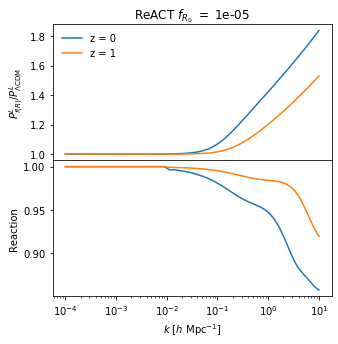

In [4]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5, 5))
fig.subplots_adjust(hspace=0)

ax[0].semilogx(k_lin, pofk_lin_MG_react[0]/pofk_lin_camb[0], label="z = 0")
ax[0].semilogx(k_lin, pofk_lin_MG_react[-1]/pofk_lin_camb[-1], label="z = 1")

ax[1].semilogx(k_lin, R[0])
ax[1].semilogx(k_lin, R[-1])

ax[0].legend(frameon=False)

ax[0].set_ylabel("$P^{L}_{f(R)}/P^{L}_{\Lambda \mathrm{CDM}}$")
ax[1].set_ylabel("Reaction")
ax[1].set_xlabel("$k$ [$h$ Mpc$^{-1}$]")

ax[0].set_title("ReACT $f_{R_0}$"+" $=$ {}".format(fR0))

Now let's try to mimic $f(R)$ gravity with EFT, we know that in this case $\alpha_K = \alpha_T = 0$, $\alpha_M = 2 \alpha_B = \frac{d f_R}{d\ln{a}} \frac{1}{1+f_R}$ and $\kappa^2 M^2 = 1 + f_R$ . 

**Note** you should set this scale factor dependency in reactions/src/BeyondLCDM.cpp in the following functions: 

* alphai_eft
* dalphai_eft
* ddalphai_eft

In [5]:
# Model selection and parameter (gr,f(r),dgp,quintessence,cpl,ds,eftppf,eftus,eftss,fulleftppf,fulleftus,fullefterf)
mymodelA = "fullefterf" # Full linear EFTofDE model with a phenomenological nonlinear Poisson modification
mymodelB = "fulleftppf" # Full linear EFTofDE model with a PPF screening nonlinear Poisson modification
mymodelC = "fulleftus" # Full linear EFTofDE model with the linear modification in the nonlinear Poisson


# Set linear theory: 

#Hu-Sawicki with n=1 
alphak0 = 0.
alphab0 = -fR0
alpham0 = -fR0
alphat0 = 0.
m2 = -fR0

# For Error function phenomenological model 
extraparsA = np.zeros(20)
extraparsA[0] = alphak0
extraparsA[1] = alphab0
extraparsA[2] = alpham0
extraparsA[3] = alphat0
extraparsA[4] = m2

# For PPF
extraparsB = np.zeros(20)

# For unscreened case
extraparsC = np.zeros(20)

# Same linear theory: 
for i in range(5):
    extraparsB[i] = extraparsA[i]
    extraparsC[i] = extraparsA[i]

    
# Set nonlinear theory:

# For phenomenological model we take valued from the paper 
extraparsA[5] = 0.75 # Screening scale 
extraparsA[6] = 0.4 # Mass dependence 
extraparsA[7] = 0.36 # environment dependence 
extraparsA[8] = 0.3 # Yukawa suppression scale

# For PPF we use the expressions in Eq. 5.6 of 1608.00522
alpha = 0.5 
omegabd = 0

extraparsB[5] = 3
extraparsB[6] = 1./(3.+2.*omegabd)
extraparsB[7] = (4.-alpha)/(1.-alpha)
extraparsB[8] = Omega_m**(1/3) * ((Omega_m + 4*(1-Omega_m))**(1/(alpha-1)) *extraparsB[5]*extraparsB[6]/fR0)**(1./extraparsB[7])
extraparsB[9] = -1
extraparsB[10] = 2/(3*extraparsB[7])
extraparsB[11] = 3/(alpha-4)


# For unscreened case there is no nonlinear parameters (we just use mu(k,a))


# This parameter scales the background function c(a). 
# Because we assume LCDM H(a) here, c(a) will not be identically 0 so we shoulds set it by hand
c0 = 0. 

extraparsA[12] = c0
extraparsB[12] = c0
extraparsC[12] = c0



In [17]:
RA, pofk_lin_EFT_reactA,sigma_8_EFTA, pseudoA = react.compute_reaction_ext(
                                h, n_s, Omega_m, Omega_b, sigma_8, z_react, k_lin, pofk_lin_camb[0], mymodelA, 
                                extraparsA, 
                                is_transfer=False, mass_loop=massloop,
                                verbose=True)  

RB, pofk_lin_EFT_reactB,sigma_8_EFTB, pseudoB = react.compute_reaction_ext(
                                h, n_s, Omega_m, Omega_b, sigma_8, z_react, k_lin, pofk_lin_camb[0], mymodelB, 
                                extraparsB, 
                                is_transfer=False, mass_loop=massloop,
                                verbose=True)  

RC, pofk_lin_EFT_reactC,sigma_8_EFTC, pseudoC = react.compute_reaction_ext(
                                h, n_s, Omega_m, Omega_b, sigma_8, z_react, k_lin, pofk_lin_camb[0], mymodelC, 
                                extraparsC, 
                                is_transfer=False, mass_loop=massloop,
                                verbose=True)  

# Check linear spectrum and reaction with exact calculation

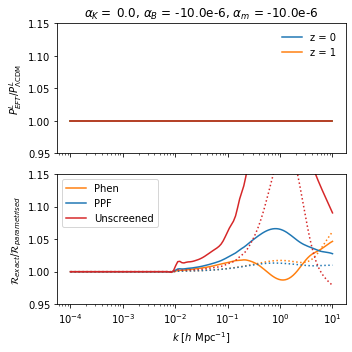

In [19]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5, 5))
fig.subplots_adjust(hspace=0)
ax[0].semilogx(k_lin, pofk_lin_EFT_reactA[0]/pofk_lin_MG_react[0], label="z = 0")
ax[0].semilogx(k_lin, pofk_lin_EFT_reactA[-1]/pofk_lin_MG_react[-1], label="z = 1")
ax[0].semilogx(k_lin, pofk_lin_EFT_reactB[0]/pofk_lin_MG_react[0])
ax[0].semilogx(k_lin, pofk_lin_EFT_reactB[-1]/pofk_lin_MG_react[-1])

ax[1].semilogx(k_lin, RA[0]/R[0], color='tab:orange',label='Phen')
ax[1].semilogx(k_lin, RA[-1]/R[-1], color='tab:orange',linestyle='dotted')
ax[1].semilogx(k_lin, RB[0]/R[0], color='tab:blue',label='PPF')
ax[1].semilogx(k_lin, RB[-1]/R[-1], color='tab:blue',linestyle='dotted')
ax[1].semilogx(k_lin, RC[0]/R[0], color='tab:red',label='Unscreened')
ax[1].semilogx(k_lin, RC[-1]/R[-1], color='tab:red',linestyle='dotted')


ax[1].legend(loc='best')
ax[0].set_ylim(0.95, 1.15)
ax[1].set_ylim(0.95, 1.15)
ax[0].legend(frameon=False)
ax[0].set_ylabel("$P^{L}_{EFT}/P^{L}_{\Lambda \mathrm{CDM}}$")
ax[1].set_ylabel("$\mathcal{R}_{exact}/\mathcal{R}_{parametrised}$")
ax[1].set_xlabel("$k$ [$h$ Mpc$^{-1}$]")
ax[0].set_title("$\\alpha_K =$ {}, $\\alpha_B$ = {}e-6, $\\alpha_m$ = {}e-6".format(round(extraparsA[0], 2),round(extraparsA[1]*10**6, 2), round(extraparsA[2]*10**6, 2)))                                
fig.tight_layout()

# Get MG non-linear power spectrum with HMCode

Hmcode needs pofk_lin at least 4 redshifts for correct interpolation!

In [8]:
import pyhmcode as hmcode

In [9]:
hmc = hmcode.Cosmology()

# Set HMcode internal cosmological parameters
hmc.om_m = Omega_c+Omega_b
hmc.om_b = Omega_b
hmc.om_v = 1.-(Omega_c+Omega_b)
hmc.h = h
hmc.ns = n_s
hmc.sig8 = sigma_8_MG
hmc.m_nu = m_nu

# Set the halo model in HMcode
# Options: HMcode2015, HMcode2016, HMcode2020
hmod = hmcode.Halomodel(hmcode.HMcode2020, verbose=False)

# Power spectrum calculation for f(R)
hmc.set_linear_power_spectrum(k_lin, np.asarray(z_react), pofk_lin_MG_react)
Pk_hm_fR = hmcode.calculate_nonlinear_power_spectrum(hmc, hmod, verbose=False)

# Power spectrum calculation for GR
hmc.sig8 = sigma_8
hmc.set_linear_power_spectrum(k_lin, np.asarray(z_react), pofk_lin_camb)
Pk_hm_GR = hmcode.calculate_nonlinear_power_spectrum(hmc, hmod, verbose=False)

Text(0.5, 1.0, '$f_{R_0}$ $=$ 1e-05')

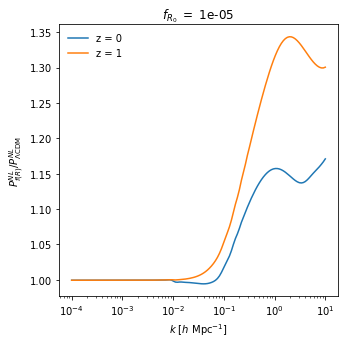

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
fig.subplots_adjust(hspace=0)

ax.semilogx(k_lin, Pk_hm_fR[0]*R[0]/Pk_hm_GR[0], label="z = 0")
ax.semilogx(k_lin, Pk_hm_fR[-1]*R[-1]/Pk_hm_GR[-1], label="z = 1")


ax.legend(frameon=False)

ax.set_ylabel("$P^{NL}_{f(R)}/P^{NL}_{\Lambda \mathrm{CDM}}$")
ax.set_xlabel("$k$ [$h$ Mpc$^{-1}$]")

ax.set_title("$f_{R_0}$"+" $=$ {}".format(fR0))
